[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching market data from Yahoo Finance...
Data retrieval complete!



Professional visualization saved as 'spy_analysis.png'
S&P GLOBAL-STYLE ETF RISK ANALYSIS REPORT
Generated: 2025-07-17 06:41:32
Annualized Volatility:    22.63%
Max Drawdown:             -33.72%
Sharpe Ratio:             0.43
Sortino Ratio:            0.53
Calmar Ratio:             0.35
Tracking Error (vs SPX):  1.13%
Note: Risk metrics calculated per S&P Global Index Methodology
CSV report saved as 'spy_risk_report.csv'

Analysis complete! Files saved:
- spy_analysis.png (Professional ETF Risk Visualization)
- spy_risk_report.csv (SEC Compliance-ready Data)
Next: Crypto Market Dashboard - Compare crypto volatility vs. SPY


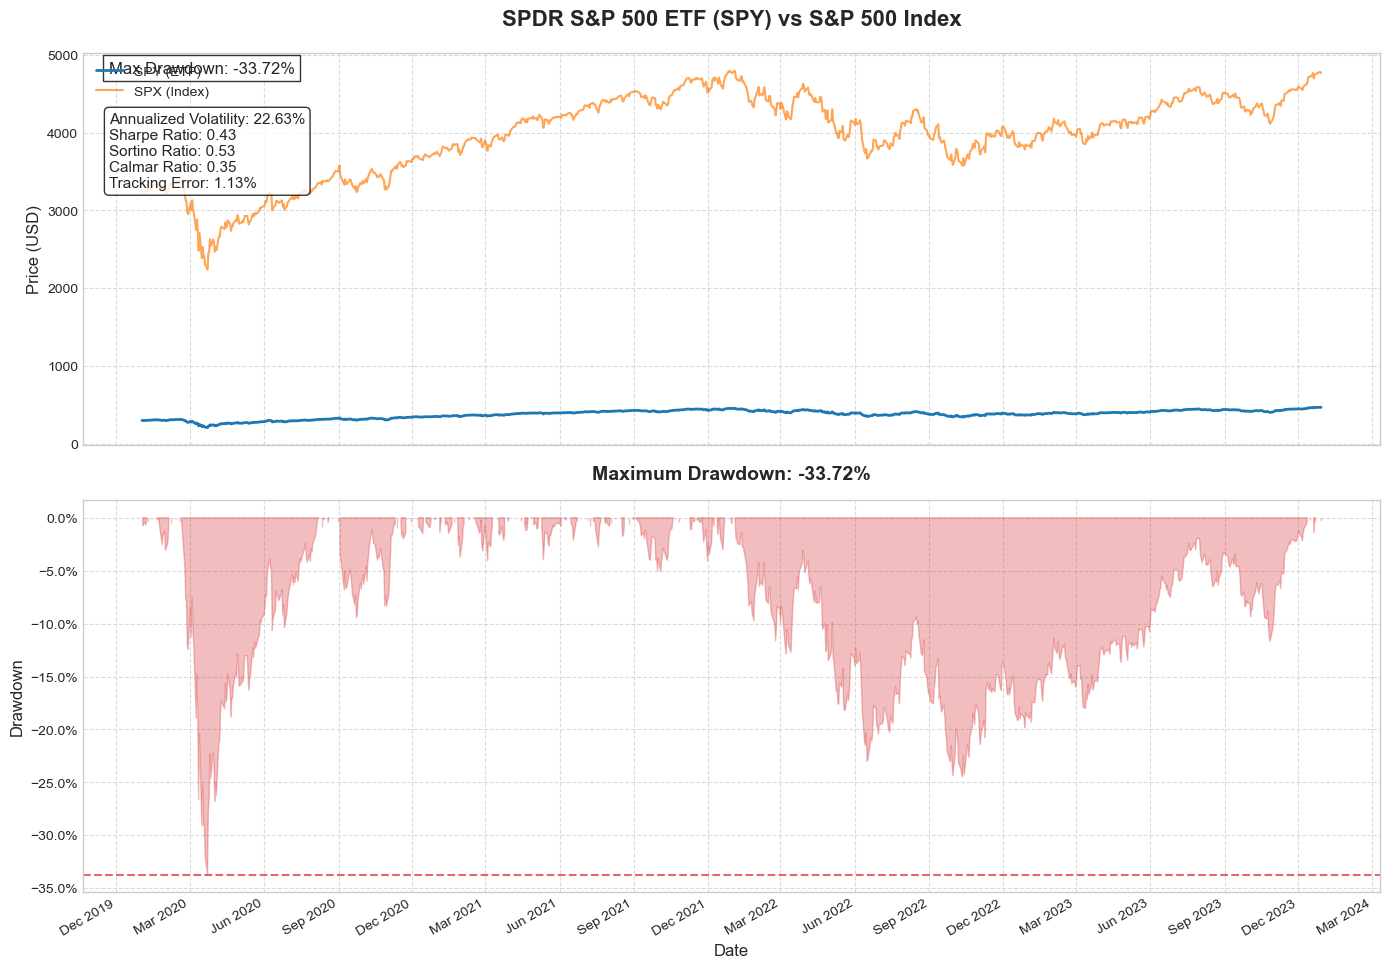

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from datetime import datetime

# Fetch S&P 500 ETF (SPY) and Index (^GSPC) data with explicit auto_adjust
print("Fetching market data from Yahoo Finance...")
spy = yf.download('SPY', start='2020-01-01', end='2023-12-31', auto_adjust=True)
spx = yf.download('^GSPC', start='2020-01-01', end='2023-12-31', auto_adjust=True)
print("Data retrieval complete!\n")

# Select only the 'Close' column
spy_close = spy['Close']
spx_close = spx['Close']

# Align both series to ensure same index for calculations and reporting
combined = pd.concat([spy_close, spx_close], axis=1, join='inner')
combined.columns = ['SPY_Close', 'SPX_Close']
combined['SPX_Close'] = combined['SPX_Close'].ffill()

# Calculate daily returns and volatility
combined['Daily_Return'] = combined['SPY_Close'].pct_change()

# Calculate drawdown
spy_peak = combined['SPY_Close'].cummax()
combined['Drawdown'] = (combined['SPY_Close'] - spy_peak) / spy_peak

# Annualized volatility
annualized_volatility = combined['Daily_Return'].std() * np.sqrt(252)
annualized_volatility = annualized_volatility if pd.notnull(annualized_volatility) else 0.0

# Max drawdown
max_drawdown = combined['Drawdown'].min()
max_drawdown = max_drawdown if pd.notnull(max_drawdown) else 0.0

# Annualized return (CAGR)
years = (combined.index[-1] - combined.index[0]).days / 365.25
annual_return = (combined['SPY_Close'].iloc[-1] / combined['SPY_Close'].iloc[0]) ** (1/years) - 1

# Sharpe Ratio
risk_free_rate = 0.02
sharpe_ratio = (annual_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0.0

# Sortino Ratio
downside_returns = combined['Daily_Return'][combined['Daily_Return'] < 0]
downside_volatility = downside_returns.std() * np.sqrt(252) if not downside_returns.empty else 0.0
sortino_ratio = (annual_return - risk_free_rate) / downside_volatility if downside_volatility != 0 else 0.0

# Calmar Ratio
calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0.0

# Tracking error (SPY vs SPX)
spy_returns_clean = combined['SPY_Close'].pct_change().dropna()
spx_returns_clean = combined['SPX_Close'].pct_change().dropna()
spy_returns_clean, spx_returns_clean = spy_returns_clean.align(spx_returns_clean, join='inner')
tracking_error = np.std(spy_returns_clean - spx_returns_clean) * np.sqrt(252)

# ---------------- Visualization -----------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price plot
ax1.plot(combined.index, combined['SPY_Close'], color='#1f77b4', linewidth=2, label='SPY (ETF)')
ax1.plot(combined.index, combined['SPX_Close'], color='#ff7f0e', linewidth=1.5, alpha=0.7, label='SPX (Index)')
ax1.set_title('SPDR S&P 500 ETF (SPY) vs S&P 500 Index', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Price (USD)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Drawdown plot
ax2.fill_between(
    combined.index,
    0,
    combined['Drawdown'].values,
    where=combined['Drawdown'].values < 0,
    color='#d62728',
    alpha=0.3
)
ax2.axhline(y=max_drawdown, color='#d62728', linestyle='--', alpha=0.7)
ax2.set_title(f'Maximum Drawdown: {max_drawdown:.2%}', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Format dates
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

# Metrics box
metrics_text = (
    f"Annualized Volatility: {annualized_volatility:.2%}\n"
    f"Sharpe Ratio: {sharpe_ratio:.2f}\n"
    f"Sortino Ratio: {sortino_ratio:.2f}\n"
    f"Calmar Ratio: {calmar_ratio:.2f}\n"
    f"Tracking Error: {tracking_error:.2%}"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax1.text(0.02, 0.85, metrics_text, transform=ax1.transAxes,
         fontsize=11, verticalalignment='top', bbox=props)

# Max drawdown annotation
ax1.text(0.02, 0.98, f"Max Drawdown: {max_drawdown:.2%}", transform=ax1.transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('spy_analysis.png', dpi=300, bbox_inches='tight')
print("Professional visualization saved as 'spy_analysis.png'")

# ---------------- Print report -----------------
print("="*60)
print("S&P GLOBAL-STYLE ETF RISK ANALYSIS REPORT")
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)
print(f"{'Annualized Volatility:':<25} {annualized_volatility:.2%}")
print(f"{'Max Drawdown:':<25} {max_drawdown:.2%}")
print(f"{'Sharpe Ratio:':<25} {sharpe_ratio:.2f}")
print(f"{'Sortino Ratio:':<25} {sortino_ratio:.2f}")
print(f"{'Calmar Ratio:':<25} {calmar_ratio:.2f}")
print(f"{'Tracking Error (vs SPX):':<25} {tracking_error:.2%}")
print("="*60)
print("Note: Risk metrics calculated per S&P Global Index Methodology")
print("="*60)

# ---------------- Generate CSV -----------------
combined.reset_index(inplace=True)
combined.to_csv('spy_risk_report.csv', index=False)
print("CSV report saved as 'spy_risk_report.csv'")

print("\nAnalysis complete! Files saved:")
print("- spy_analysis.png (Professional ETF Risk Visualization)")
print("- spy_risk_report.csv (SEC Compliance-ready Data)")
print("="*60)
print("Next: Crypto Market Dashboard - Compare crypto volatility vs. SPY")

